# Postprocessing

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
#%load_ext line_profiler
#%load_ext snakeviz
%autoreload 2

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import corner

import pickle

import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const

from enterprise_extensions import deterministic

from scipy.stats import norm

import libstempo as T2
import libstempo.toasim as LT
import libstempo.plot as LP

import glob
import json
import h5py
import healpy as hp
import scipy.constants as sc
import emcee

from numba.typed import List

import sys
import h5py

## Load run + general diagnostics

In [2]:
pwd

'/scratch/na00078/QuickCW_targeted_runs/post_processing_scripts'

In [3]:
#COMMENT IF OUTFILE GENERATED
#Thinning script for one source
i = "/scratch/na00078/QuickCW_targeted_runs/results/3C66B_detect_6_6_outfile.h5"

infile = i
first_n_param = 8
# outfile = '/scratch/na00078/QuickCW_targeted_runs/results/3C66B_outfile.h5'

print(infile)
print(first_n_param)

with h5py.File(infile, 'r') as f:
    Ts = f['T-ladder'][...]
    samples_cold = f['samples_cold'][:,:,:first_n_param]
    print(samples_cold[-1].shape)
    log_likelihood = f['log_likelihood'][:1,:]
    print(log_likelihood.shape)
    par_names = [x.decode('UTF-8') for x in list(f['par_names'])]
    acc_fraction = f['acc_fraction'][...]
    fisher_diag = f['fisher_diag'][...]

/scratch/na00078/QuickCW_targeted_runs/results/3C66B_detect_6_6_outfile.h5
8
(100000000, 8)
(1, 100000000)


In [4]:
'''from enterprise import constants as const

log10_mc = 7
log10_fgw = np.log10(6.0358262e-8)
print(log10_fgw)
#dist = 93.6
log10_h = -18

mc = 10**log10_mc * const.Tsun
fgw = 10**log10_fgw
#gwtheta = np.arccos(cos_gwtheta)
#inc = np.arccos(cos_inc)
#p_dist = (pdist[0] + pdist[1]*p_dist)*const.kpc/const.c

#if log10_h is None and log10_dist is None:
 #   raise ValueError("one of log10_dist or log10_h must be non-None")
#elif log10_h is not None and log10_dist is not None:
 #   raise ValueError("only one of log10_dist or log10_h can be non-None")
#elif log10_h is None:
 #   dist = 10**log10_dist * const.Mpc / const.c
#else

dist = 2 * mc**(5/3) * (np.pi*fgw)**(2/3) / 10**log10_h

print(dist)
'''

'from enterprise import constants as const\n\nlog10_mc = 7\nlog10_fgw = np.log10(6.0358262e-8)\nprint(log10_fgw)\n#dist = 93.6\nlog10_h = -18\n\nmc = 10**log10_mc * const.Tsun\nfgw = 10**log10_fgw\n#gwtheta = np.arccos(cos_gwtheta)\n#inc = np.arccos(cos_inc)\n#p_dist = (pdist[0] + pdist[1]*p_dist)*const.kpc/const.c\n\n#if log10_h is None and log10_dist is None:\n #   raise ValueError("one of log10_dist or log10_h must be non-None")\n#elif log10_h is not None and log10_dist is not None:\n #   raise ValueError("only one of log10_dist or log10_h can be non-None")\n#elif log10_h is None:\n #   dist = 10**log10_dist * const.Mpc / const.c\n#else\n\ndist = 2 * mc**(5/3) * (np.pi*fgw)**(2/3) / 10**log10_h\n\nprint(dist)\n'

hamp [4.3013709e-16 4.0577735e-16 3.6649803e-16 ... 1.5905861e-14 1.5016707e-14
 1.4469540e-14]
freq [5.630444e-08 5.630444e-08 5.630444e-08 ... 6.256698e-08 6.256698e-08
 6.256698e-08]
mc [5.1909536e+07 5.1909536e+07 5.1909536e+07 ... 2.9554589e+08 2.9554589e+08
 2.9554589e+08]
Length of logdL 90000000
required values 7.3722997 5.630444e-08 51909536.0 3.1089027e-17
dL min 92.66399999999999
dL max 94.536
10**log10_d_L [14.660106  15.540186  17.2057    ...  7.7212005  8.17838    8.487647 ]
min 10**log10_d_L 0.0018580372
max 10**log10_d_L 23566748.0
d_L_mask [     551      651     1251 ... 89991873 89992532 89994894]
notd_L_mask1 [       0        1        2 ... 89999997 89999998 89999999]
notd_L_mask2 [       4        5        9 ... 89998191 89998192 89999882]
merged_non_dL [       0        1        2 ... 89998191 89998192 89999882]
Sample shape (90000000, 9)
dL_mask length 131083
5


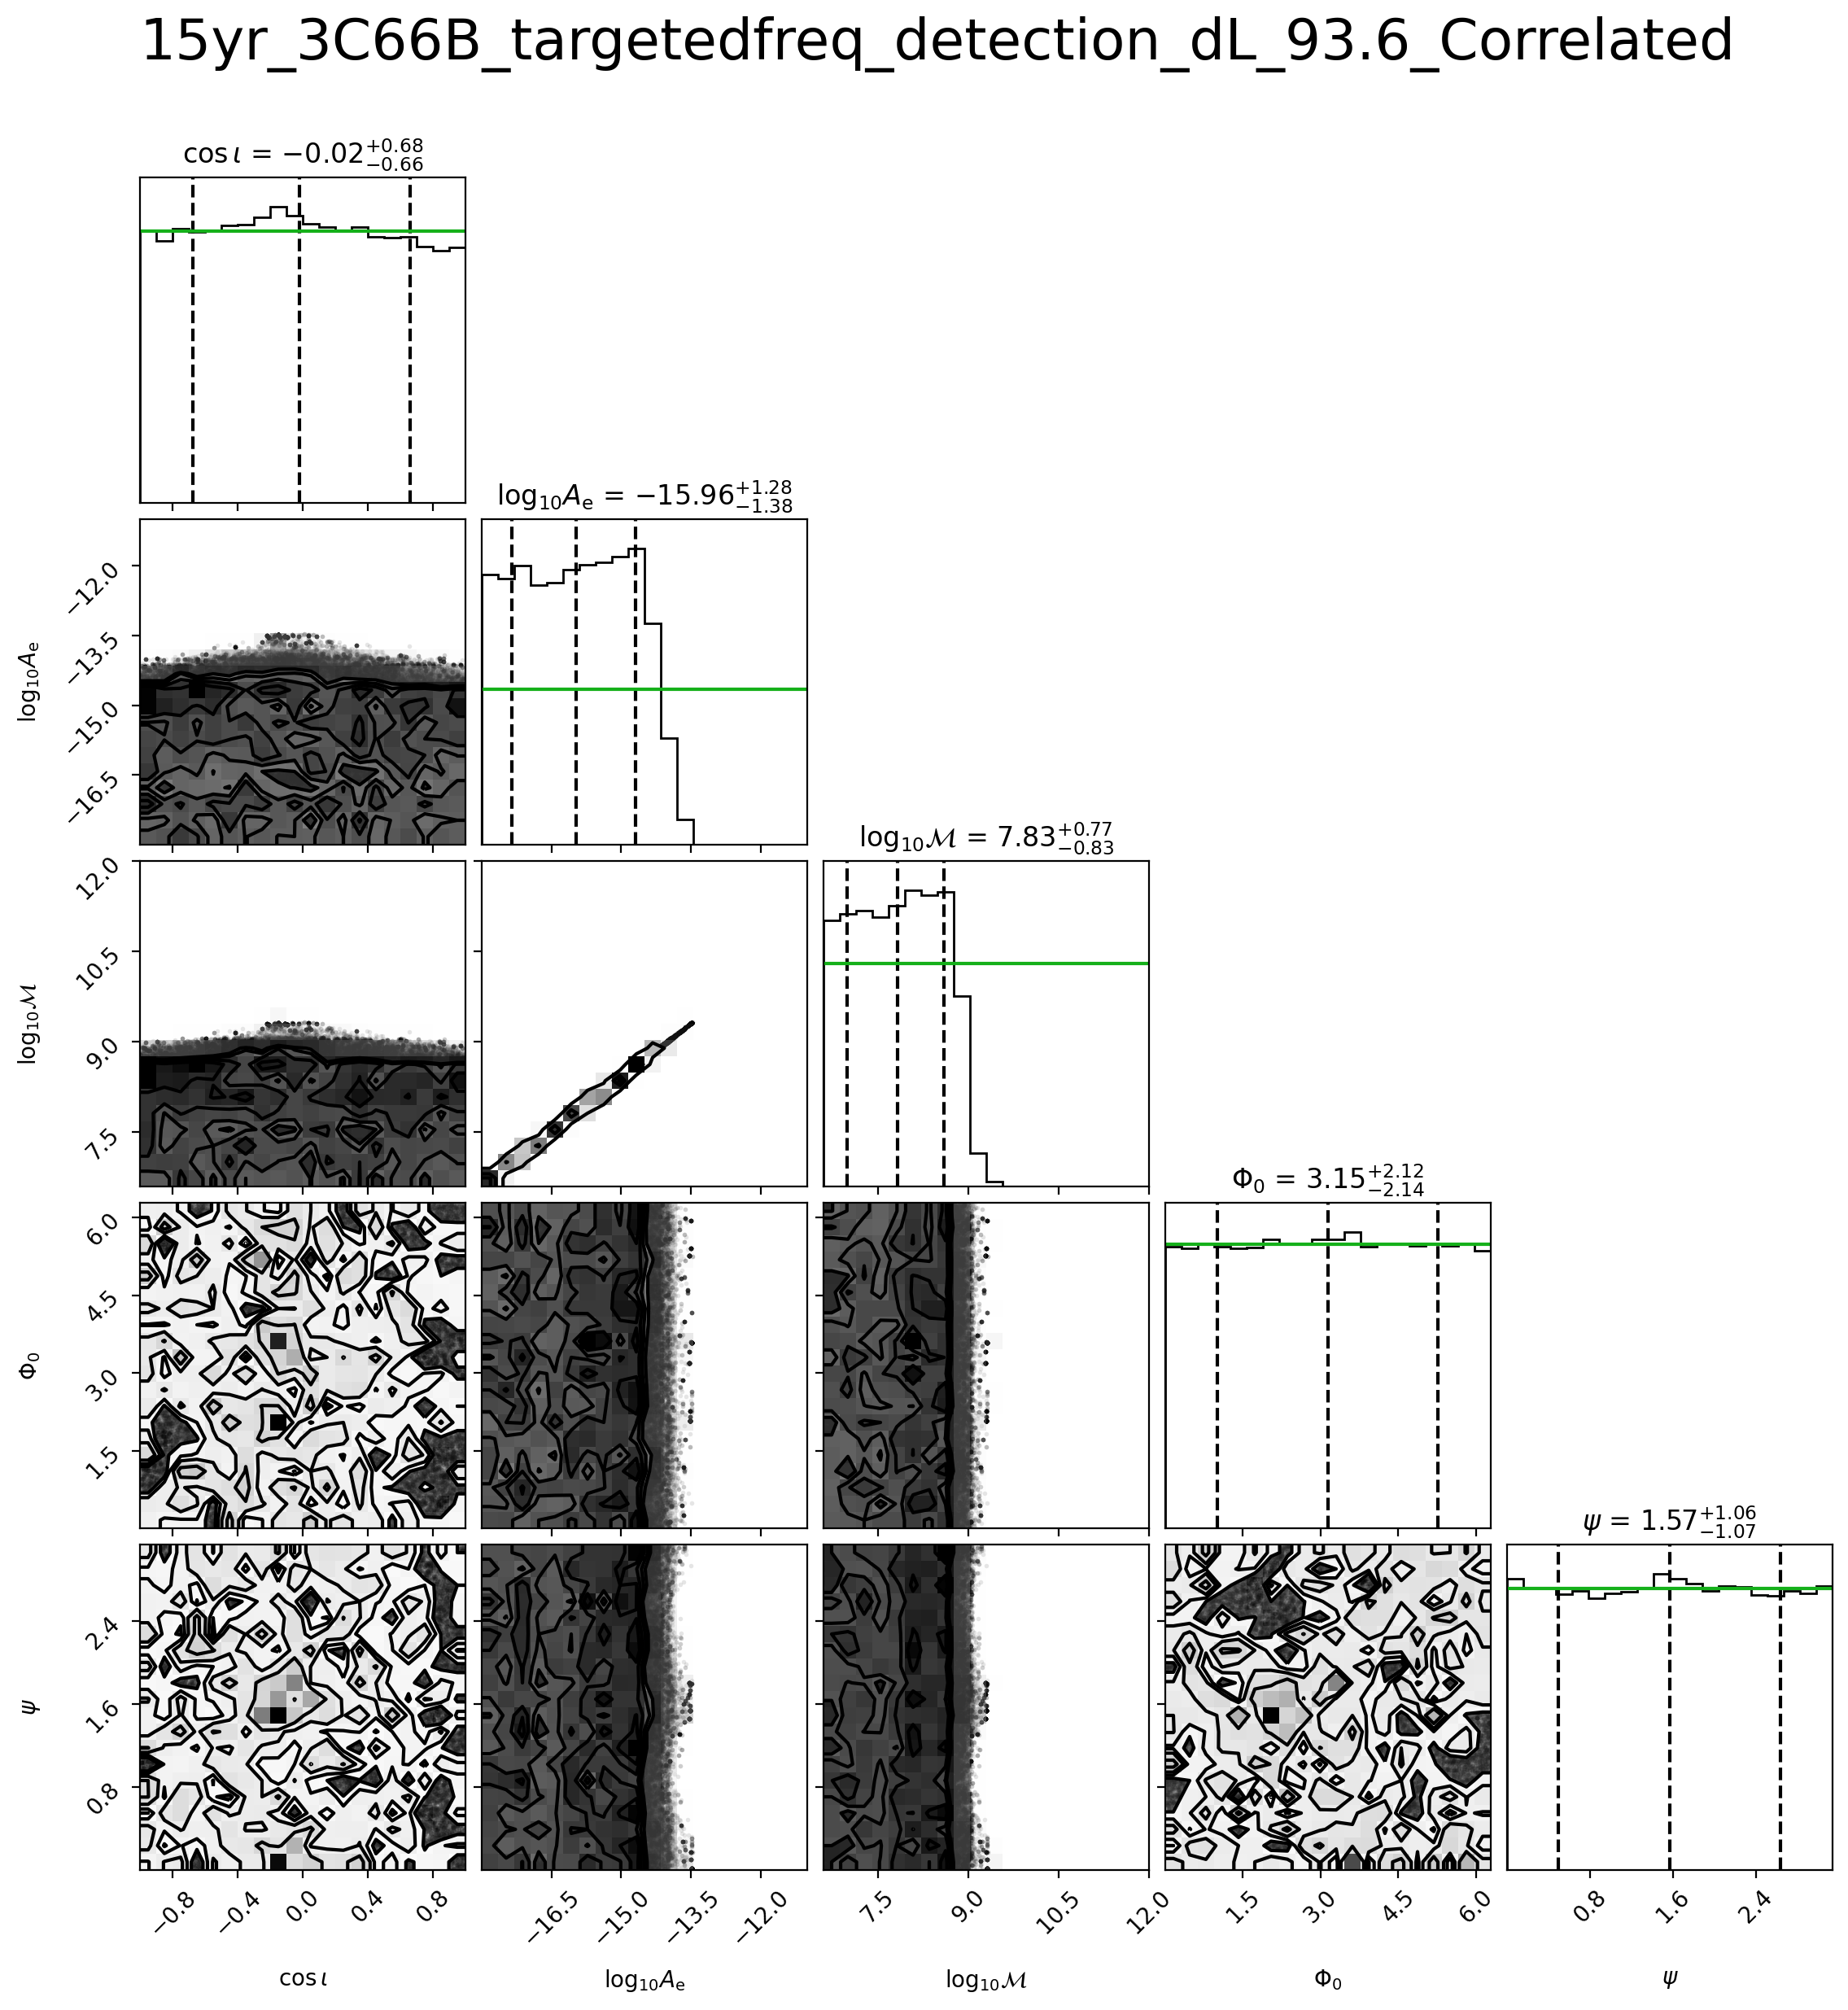

In [5]:
#corner plot of parameters common to all pulsars (Contains Luminosity distance)
corner_mask = [0, 1, 2, 3, 4, 5, 6, 7]
par_keys = ["0_cos_gwtheta", "0_cos_inc", "0_gwphi", "0_log10_fgw",
          "0_log10_h", "0_log10_mc", "0_phase0", "0_psi","log10_d_L"]
#labels = [r"$\cos \theta$", r"$\cos \iota$", r"$\phi$", r"$\log_{10} f_{\rm GW}$",
      #    r"$\log_{10} A_{\rm e}$", r"$\log_{10} {\cal M}$", r"$\Phi_0$", r"$\psi$",r"$\log_{10} d_L$"]
labels = [r"$\cos \iota$", r"$\log_{10} A_{\rm e}$", r"$\log_{10} {\cal M}$", r"$\Phi_0$",r"$\psi$"]


#set burnin and thinning
#burnin = 0
#burnin = 500_000
burnin = int(1e7)
thin = 1

#set ranges
ranges = [(-1,1), (-18,-11), (6.6,12), (0,2*np.pi), (0,np.pi)]
#ranges = [(-1,1), (-1,1), (0,2*np.pi), (-8.704,np.log10(3e-7)), (-18,-11), (6.6,12), (0,2*np.pi), (0,np.pi), (0,10)]
#ranges = [0.99]*9


megaparsec = 3.086e+22 #meter
speed_of_light = 299792458.0 #m/s
T_sun = 1.327124400e20 / speed_of_light**3 #G*M_sun/c^3 = R_sun/c-->Sun time

############################################################################
h_amp = 10**samples_cold[0][burnin::thin,4]
fff = 10**samples_cold[0][burnin::thin,3]
mmm = 10**samples_cold[0][burnin::thin,5]

print('hamp',h_amp)
print('freq',fff)
print('mc',mmm)

log10_d_L = np.log10(2 * (mmm*T_sun)**(5/3) * (np.pi*fff)**(2/3) / h_amp *speed_of_light/megaparsec)
print("Length of logdL", len(log10_d_L))
print("required values",np.max(log10_d_L), fff[1000], mmm[1000], h_amp[1000] )
#####################################
target_d_L = 93.6#Mpc
d_L_percent_tolerance = 1.0
#####################################

d_L_min = target_d_L*(1-d_L_percent_tolerance/100)
d_L_max = target_d_L*(1+d_L_percent_tolerance/100)
print("dL min",d_L_min)
print("dL max",d_L_max)
print("10**log10_d_L",10**log10_d_L)
print("min 10**log10_d_L",np.min(10**log10_d_L))
print("max 10**log10_d_L",np.max(10**log10_d_L))

d_L_mask = np.where((10**log10_d_L>=d_L_min) & (10**log10_d_L<=d_L_max))[0]
print("d_L_mask",d_L_mask)

#########################
not_d_L_mask_1 = np.where((10**log10_d_L<d_L_min))[0] #& (10**log10_d_L>d_L_max))[0]
print("notd_L_mask1",not_d_L_mask_1)
not_d_L_mask_2 = np.where((10**log10_d_L>d_L_max))[0] #& ())[0]
print("notd_L_mask2",not_d_L_mask_2)

merged_non_dL = np.concatenate((not_d_L_mask_1,not_d_L_mask_2))
print("merged_non_dL",merged_non_dL)
########################################

samples2plot = np.concatenate((samples_cold[0][burnin::thin,corner_mask], np.array([log10_d_L,]).T), axis=1)

print("Sample shape", samples2plot.shape)
print("dL_mask length", len(d_L_mask))
print(len(ranges))

samples2plot_detect = np.vstack((
                          samples2plot[d_L_mask,1],
                          samples2plot[d_L_mask,4],
                          samples2plot[d_L_mask,5],
                          samples2plot[d_L_mask,6],
                          samples2plot[d_L_mask,7])).T


fig = corner.corner(samples2plot_detect,
                    labels=labels,
                    show_titles=True, quantiles=[0.16, 0.5, 0.84],
                    range=ranges, hist_kwargs={"density":True})

#plot priors over 1D posteriors
for i, ax in enumerate(fig.axes):
    if i==0:#(len(labels)+1): #cos inc and cos theta
        Xs = np.linspace(-1,1)
        ax.plot(Xs, Xs*0+1/2, color="xkcd:green")
    #elif i==3*(len(labels)+1): #log10_fgw
     #   Xs = np.linspace(np.log10(3.5e-9), -7.0)
        # Y = plot_Gaussian(Xs,np.log10(1.13e-8),1)
        # ax.plot(Xs,Y, color='xkcd:green')
      #  ax.plot(Xs, Xs*0+1/(np.log10(3e-7)+8.704), color="xkcd:green")
    elif i==(len(labels)+1): #log10_A
        Xs = np.linspace(-18, -11)
        ax.plot(Xs, Xs*0+1/7, color="xkcd:green")
    elif i==2*(len(labels)+1): #log10_M_ch
        Xs = np.linspace(6.6, 12)
        # Y=plot_Gaussian(Xs,9.86,1)
        # ax.plot(Xs,Y, color='xkcd:green')
        ax.plot(Xs, Xs*0+1/3, color="xkcd:green")
    elif i==3*(len(labels)+1): #gwphi and phase0
        Xs = np.linspace(0,2*np.pi)
        ax.plot(Xs, Xs*0+1/(2*np.pi), color="xkcd:green")
    elif i==4*(len(labels)+1): #psi
        Xs = np.linspace(0,np.pi)
        ax.plot(Xs, Xs*0+1/np.pi, color="xkcd:green")
        
fig.suptitle('15yr_3C66B_targetedfreq_detection_dL_93.6_Correlated', fontsize = 25,y=1.05);

hamp [4.3013709e-16 4.0577735e-16 3.6649803e-16 ... 1.5905861e-14 1.5016707e-14
 1.4469540e-14]
freq [5.630444e-08 5.630444e-08 5.630444e-08 ... 6.256698e-08 6.256698e-08
 6.256698e-08]
mc [5.1909536e+07 5.1909536e+07 5.1909536e+07 ... 2.9554589e+08 2.9554589e+08
 2.9554589e+08]
Length of logdL 90000000
required values 7.3722997e+00 5.630444e-08 51909536.0 3.1089027e-17
dL min 92.66399999999999
dL max 94.536
10**log10_d_L [14.660106  15.540186  17.2057    ...  7.7212005  8.17838    8.487647 ]
min 10**log10_d_L 0.0018580372
max 10**log10_d_L 23566748.0
d_L_mask [     551      651     1251 ... 89991873 89992532 89994894]
notd_L_mask1 [       0        1        2 ... 89999997 89999998 89999999]
notd_L_mask2 [       4        5        9 ... 89998191 89998192 89999882]
merged_non_dL [       0        1        2 ... 89998191 89998192 89999882]
Sample shape (90000000, 9)
dL_mask length 131083
9


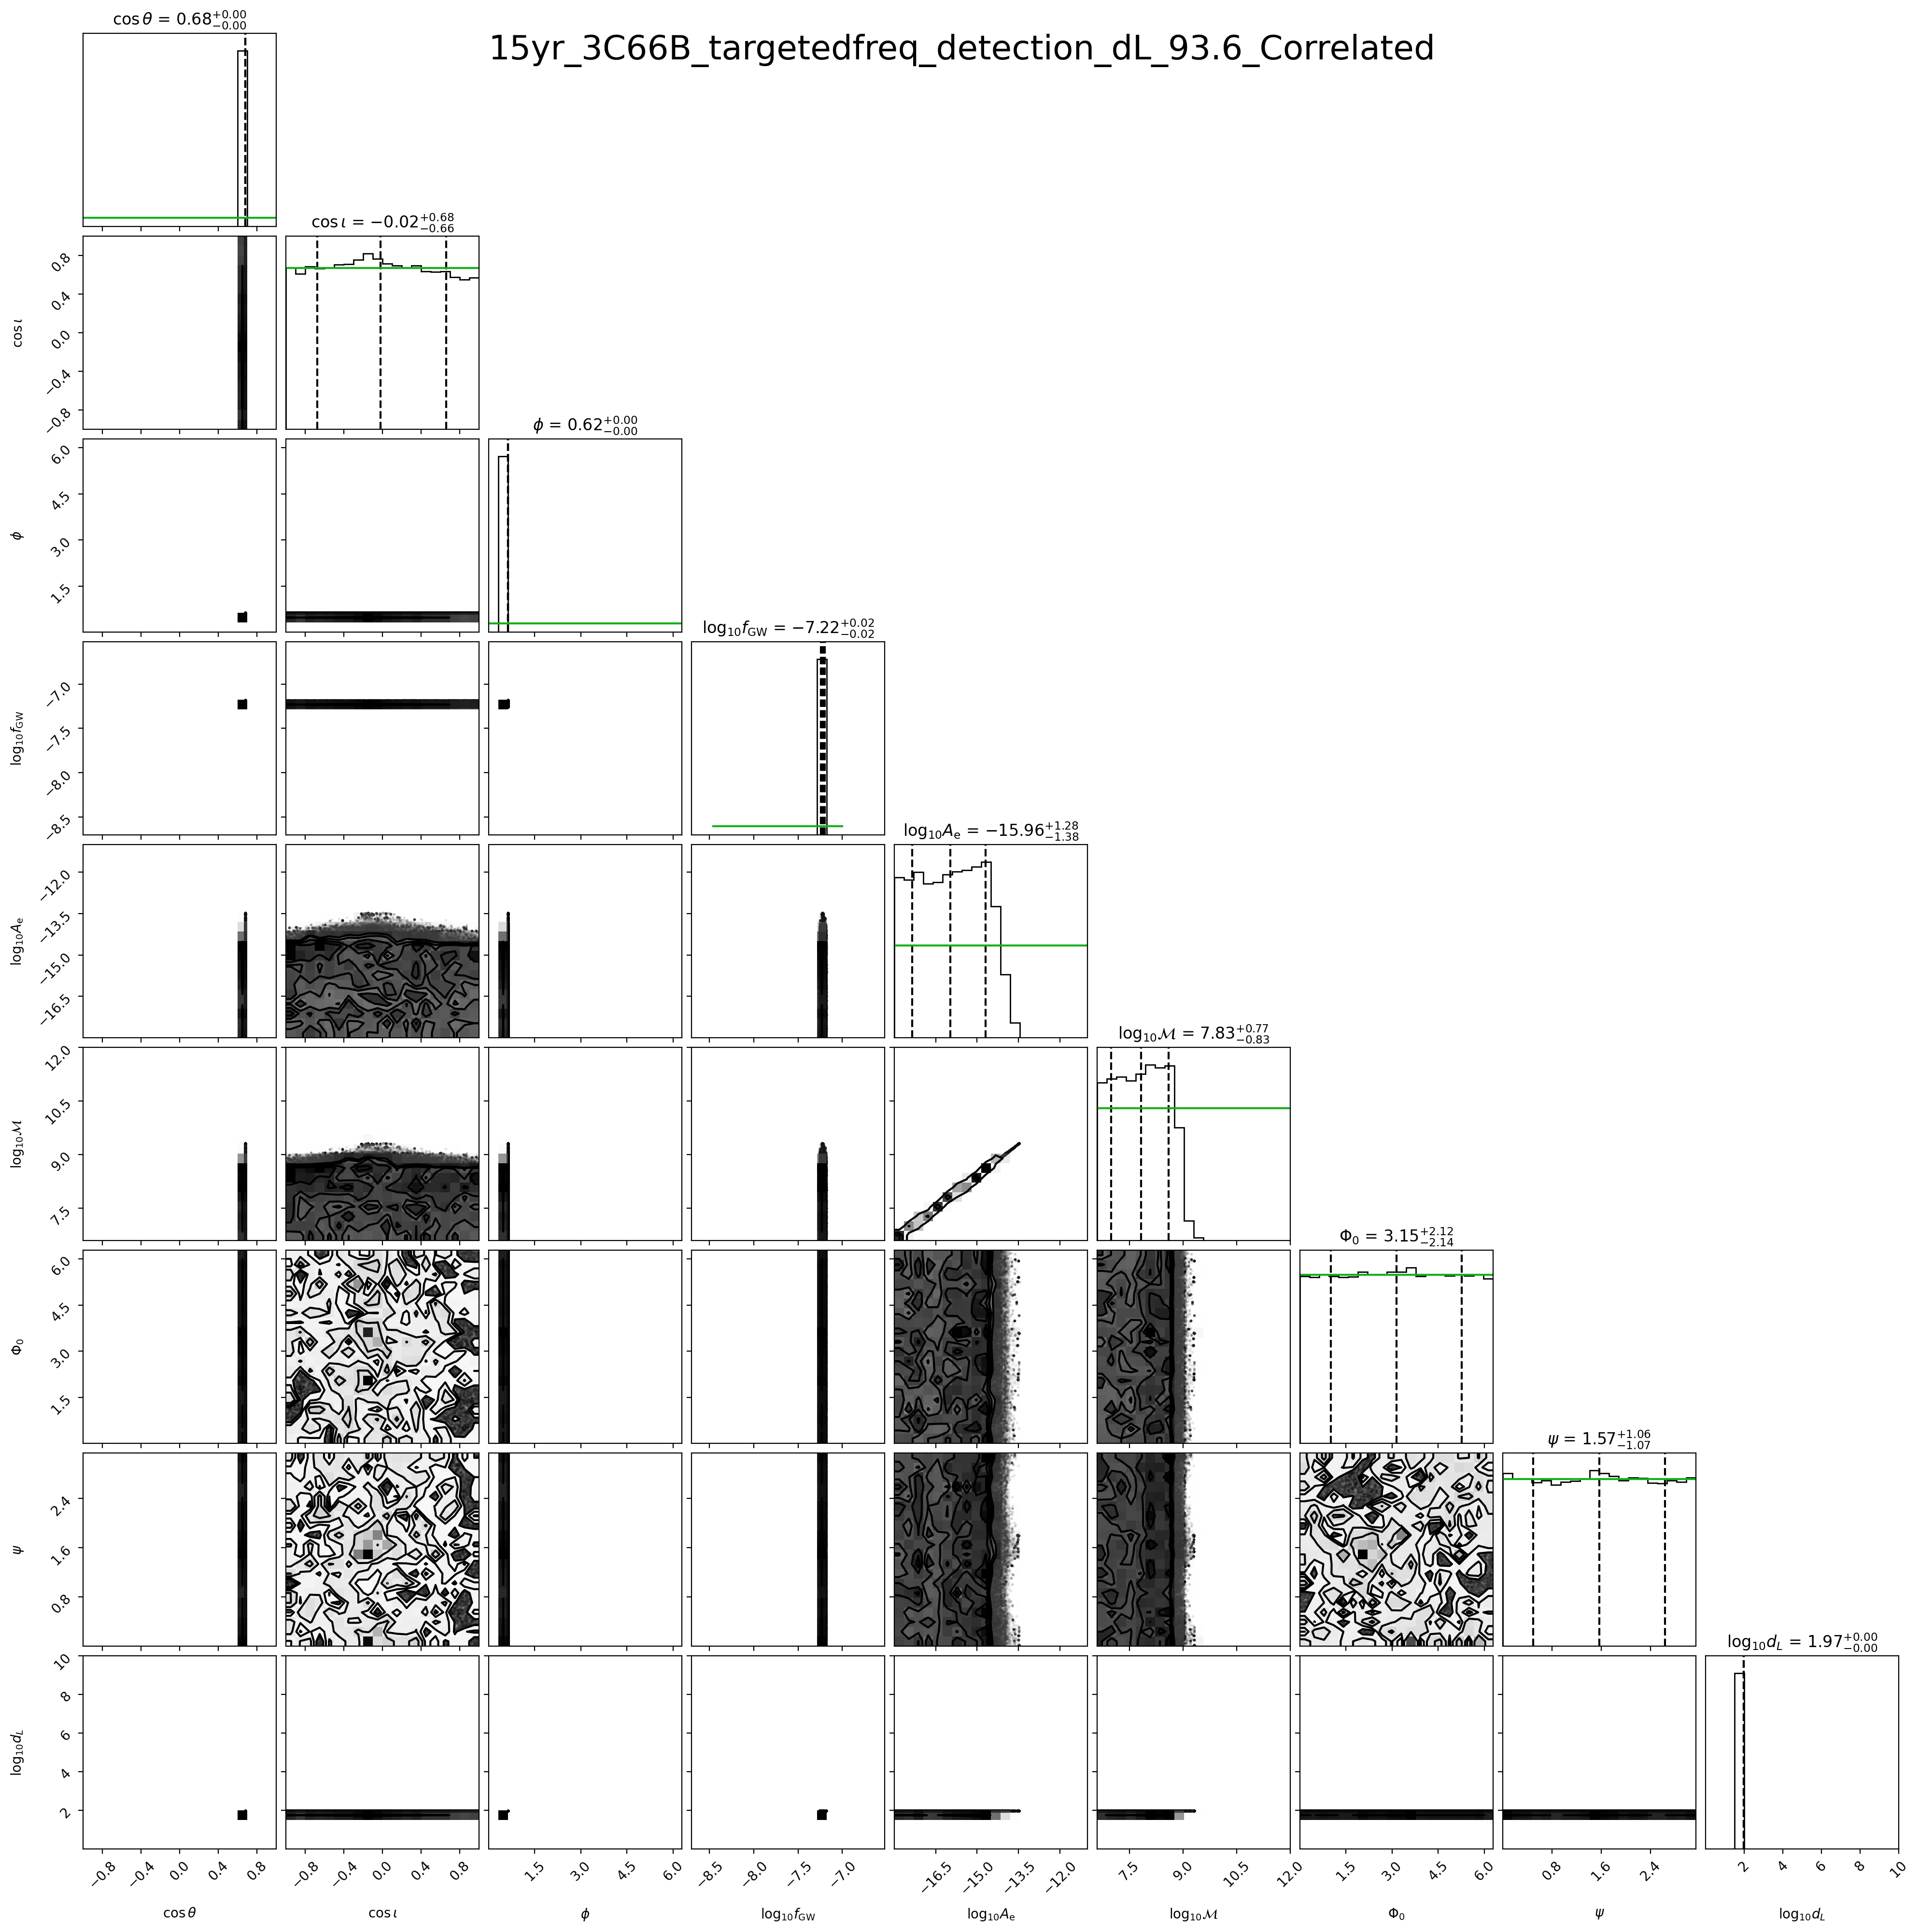

In [6]:
#corner plot of parameters common to all pulsars (Contains Luminosity distance)
corner_mask = [0, 1, 2, 3, 4, 5, 6, 7]
par_keys = ["0_cos_gwtheta", "0_cos_inc", "0_gwphi", "0_log10_fgw",
          "0_log10_h", "0_log10_mc", "0_phase0", "0_psi","log10_d_L"]
labels = [r"$\cos \theta$", r"$\cos \iota$", r"$\phi$", r"$\log_{10} f_{\rm GW}$",
          r"$\log_{10} A_{\rm e}$", r"$\log_{10} {\cal M}$", r"$\Phi_0$", r"$\psi$",r"$\log_{10} d_L$"]

#set burnin and thinning
#burnin = 0
#burnin = 500_000
burnin = int(1e7)
thin = 1

#set ranges
ranges = [(-1,1), (-1,1), (0,2*np.pi), (-8.704,np.log10(3e-7)), (-18,-11), (6.6,12), (0,2*np.pi), (0,np.pi), (0,10)]
#ranges = [0.99]*9


megaparsec = 3.086e+22 #meter
speed_of_light = 299792458.0 #m/s
T_sun = 1.327124400e20 / speed_of_light**3 #G*M_sun/c^3 = R_sun/c-->Sun time

############################################################################
h_amp = 10**samples_cold[0][burnin::thin,4]
fff = 10**samples_cold[0][burnin::thin,3]
mmm = 10**samples_cold[0][burnin::thin,5]

print('hamp',h_amp)
print('freq',fff)
print('mc',mmm)

log10_d_L = np.log10(2 * (mmm*T_sun)**(5/3) * (np.pi*fff)**(2/3) / h_amp *speed_of_light/megaparsec)
print("Length of logdL", len(log10_d_L))
print("required values",np.max(log10_d_L), fff[1000], mmm[1000], h_amp[1000] )
#####################################
target_d_L = 93.6#85.8#93.6#Mpc
d_L_percent_tolerance = 1.0
#####################################

d_L_min = target_d_L*(1-d_L_percent_tolerance/100)
d_L_max = target_d_L*(1+d_L_percent_tolerance/100)
print("dL min",d_L_min)
print("dL max",d_L_max)
print("10**log10_d_L",10**log10_d_L)
print("min 10**log10_d_L",np.min(10**log10_d_L))
print("max 10**log10_d_L",np.max(10**log10_d_L))

d_L_mask = np.where((10**log10_d_L>=d_L_min) & (10**log10_d_L<=d_L_max))[0]
print("d_L_mask",d_L_mask)

#########################
not_d_L_mask_1 = np.where((10**log10_d_L<d_L_min))[0] #& (10**log10_d_L>d_L_max))[0]
print("notd_L_mask1",not_d_L_mask_1)
not_d_L_mask_2 = np.where((10**log10_d_L>d_L_max))[0] #& ())[0]
print("notd_L_mask2",not_d_L_mask_2)

merged_non_dL = np.concatenate((not_d_L_mask_1,not_d_L_mask_2))
print("merged_non_dL",merged_non_dL)
########################################

samples2plot = np.concatenate((samples_cold[0][burnin::thin,corner_mask], np.array([log10_d_L,]).T), axis=1)

print("Sample shape", samples2plot.shape)
print("dL_mask length", len(d_L_mask))
print(len(ranges))
fig = corner.corner(samples2plot[d_L_mask, :],
                    labels=labels,
                    show_titles=True, quantiles=[0.16, 0.5, 0.84],
                    range=ranges, hist_kwargs={"density":True})

#plot priors over 1D posteriors
for i, ax in enumerate(fig.axes):
    if i==0 or i==(len(labels)+1): #cos inc and cos theta
        Xs = np.linspace(-1,1)
        ax.plot(Xs, Xs*0+1/2, color="xkcd:green")
    elif i==2*(len(labels)+1) or i==6*(len(labels)+1): #gwphi and phase0
        Xs = np.linspace(0,2*np.pi)
        ax.plot(Xs, Xs*0+1/(2*np.pi), color="xkcd:green")
    elif i==3*(len(labels)+1): #log10_fgw
        Xs = np.linspace(np.log10(3.5e-9), -7.0)
        # Y = plot_Gaussian(Xs,np.log10(1.13e-8),1)
        # ax.plot(Xs,Y, color='xkcd:green')
        ax.plot(Xs, Xs*0+1/(np.log10(3e-7)+8.704), color="xkcd:green")
    elif i==4*(len(labels)+1): #log10_A
        Xs = np.linspace(-18, -11)
        ax.plot(Xs, Xs*0+1/7, color="xkcd:green")
    elif i==5*(len(labels)+1): #log10_M_ch
        Xs = np.linspace(6.6, 12)
        # Y=plot_Gaussian(Xs,9.86,1)
        # ax.plot(Xs,Y, color='xkcd:green')
        ax.plot(Xs, Xs*0+1/3, color="xkcd:green")
    elif i==7*(len(labels)+1): #psi
        Xs = np.linspace(0,np.pi)
        ax.plot(Xs, Xs*0+1/np.pi, color="xkcd:green")
        
fig.suptitle('15yr_3C66B_targetedfreq_detection_dL_93.6_Correlated', fontsize = 25);

In [7]:
'''#corner plot of parameters common to all pulsars UNIFORM PRIOR

corner_mask = [0, 1, 2, 3, 4, 5, 6, 7]
par_keys = ["0_cos_gwtheta", "0_cos_inc", "0_gwphi", "0_log10_fgw",
          "0_log10_h", "0_log10_mc", "0_phase0", "0_psi"]
labels = [r"$\cos \theta$", r"$\cos \iota$", r"$\phi$", r"$\log_{10} f_{\rm GW}$",
          r"$\log_{10} A_{\rm e}$", r"$\log_{10} {\cal M}$", r"$\Phi_0$", r"$\psi$"]


#set ranges
ranges = [(-1,1), (-1,1), (0,2*np.pi), (np.log10(3.5e-9),-7), (-18,-11), (7,12), (0,2*np.pi), (0,np.pi) ]

#set burnin and thinning
burnin = 10000000
thin = 1

#truth = [xxx[key] for key in par_keys]
fig = corner.corner(samples_cold[0][burnin::thin,corner_mask], labels=labels, show_titles=True, range=ranges, hist_kwargs={"density":True})# quantiles=[0.16, 0.5, 0.84],
                    #truths=truth

#plot priors over 1D posteriors
for i, ax in enumerate(fig.axes):
    if i==0 or i==(len(labels)+1): #cos inc and cos theta
        Xs = np.linspace(-1,1)
        ax.plot(Xs, Xs*0+1/2, color="xkcd:green")
    elif i==2*(len(labels)+1) or i==6*(len(labels)+1): #gwphi and phase0
        Xs = np.linspace(0,2*np.pi)
        ax.plot(Xs, Xs*0+1/(2*np.pi), color="xkcd:green")
    elif i==3*(len(labels)+1): #log10_fgw
        Xs = np.linspace(np.log10(3.5e-9), -7.0)
        ax.plot(Xs, Xs*0+1/(-7-np.log10(3.5e-9)), color="xkcd:green")
    elif i==4*(len(labels)+1): #log10_A
        Xs = np.linspace(-18, -11)
        ax.plot(Xs, Xs*0+1/7, color="xkcd:green")
    elif i==5*(len(labels)+1): #log10_M_ch
        Xs = np.linspace(7, 12)
        ax.plot(Xs, Xs*0+1/3, color="xkcd:green")
    elif i==7*(len(labels)+1): #psi
        Xs = np.linspace(0,np.pi)
        ax.plot(Xs, Xs*0+1/np.pi, color="xkcd:green")
        
fig.suptitle('3C66B_targetedfreq_detection_non_dL_correlated', fontsize = 25);
'''

'#corner plot of parameters common to all pulsars UNIFORM PRIOR\n\ncorner_mask = [0, 1, 2, 3, 4, 5, 6, 7]\npar_keys = ["0_cos_gwtheta", "0_cos_inc", "0_gwphi", "0_log10_fgw",\n          "0_log10_h", "0_log10_mc", "0_phase0", "0_psi"]\nlabels = [r"$\\cos \theta$", r"$\\cos \\iota$", r"$\\phi$", r"$\\log_{10} f_{\rm GW}$",\n          r"$\\log_{10} A_{\rm e}$", r"$\\log_{10} {\\cal M}$", r"$\\Phi_0$", r"$\\psi$"]\n\n\n#set ranges\nranges = [(-1,1), (-1,1), (0,2*np.pi), (np.log10(3.5e-9),-7), (-18,-11), (7,12), (0,2*np.pi), (0,np.pi) ]\n\n#set burnin and thinning\nburnin = 10000000\nthin = 1\n\n#truth = [xxx[key] for key in par_keys]\nfig = corner.corner(samples_cold[0][burnin::thin,corner_mask], labels=labels, show_titles=True, range=ranges, hist_kwargs={"density":True})# quantiles=[0.16, 0.5, 0.84],\n                    #truths=truth\n\n#plot priors over 1D posteriors\nfor i, ax in enumerate(fig.axes):\n    if i==0 or i==(len(labels)+1): #cos inc and cos theta\n        Xs = np.linspace(-

# SD BF

-1.7999985e+01
131083


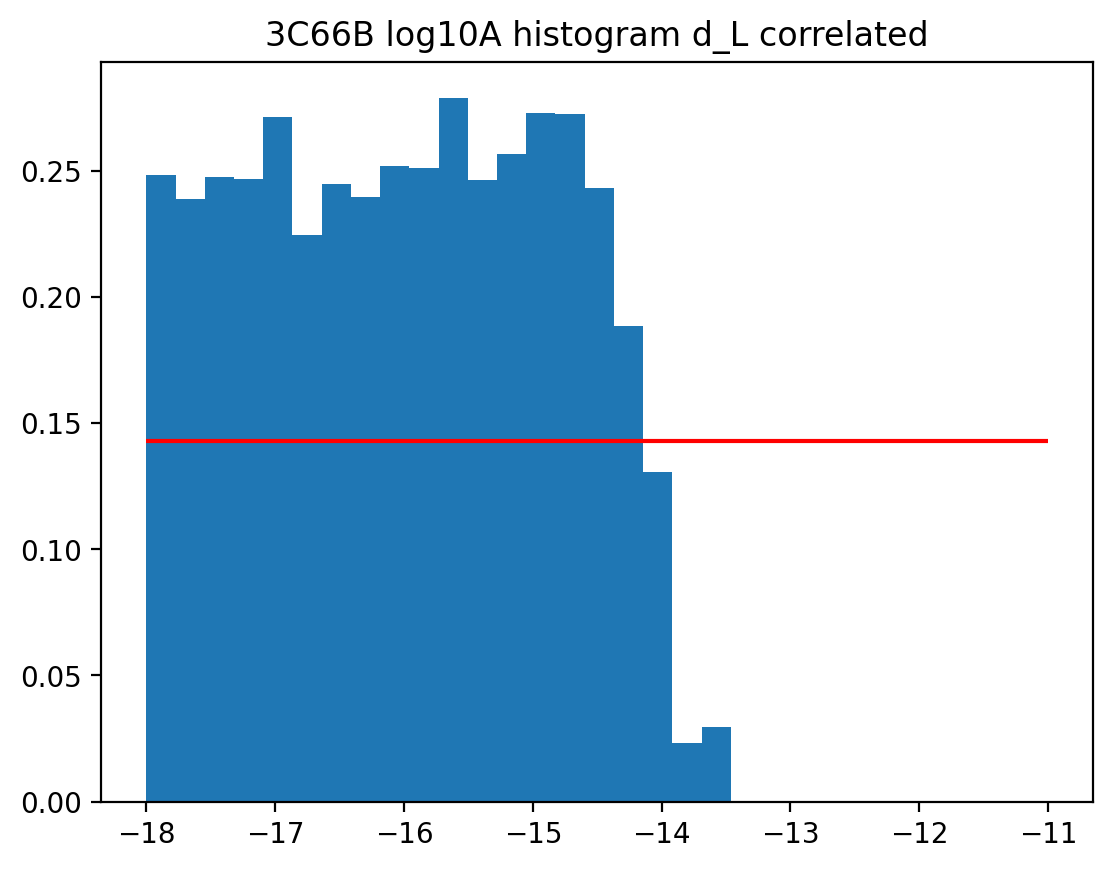

In [8]:
logAmin_dL = np.min(samples2plot[d_L_mask,4])
logAmax_dL = np.max(samples2plot[d_L_mask,4])
print(logAmin_dL)
print(len(samples2plot[d_L_mask,4]))

plt.hist(samples2plot[d_L_mask,4], bins=20, density=True)
plt.hlines(1/(-11 - logAmin_dL), logAmin_dL, -11,  color='red')
plt.title("3C66B log10A histogram d_L correlated")
plt.show()

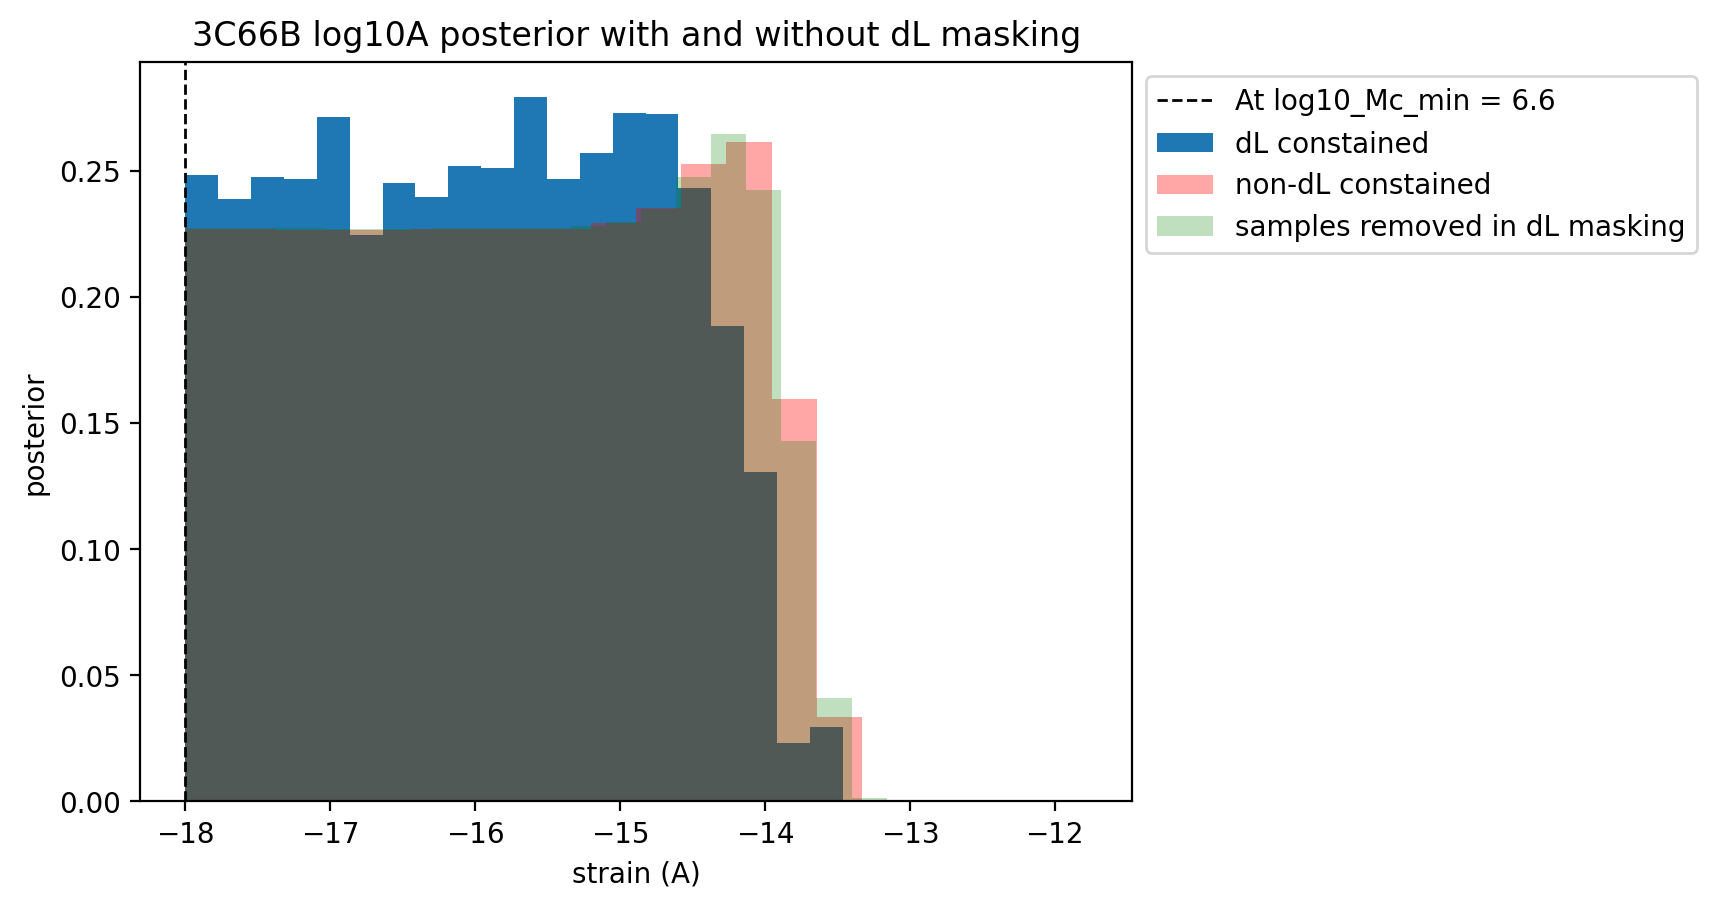

In [11]:
#logAmin_dL = np.min(samples2plot[d_L_mask,4])
#logAmax_dL = np.max(samples2plot[d_L_mask,4])
#print(logAmin_dL)
#print(len(samples2plot[d_L_mask,4]))

label = ['At log10_Mc_min = 6.6','dL constained', 'non-dL constained', 'samples removed in dL masking',]

plt.hist(samples2plot[d_L_mask,4], bins=20, density=True)
plt.hist(samples_cold[0][::10,4], bins=20, density=True,color = 'red',alpha=0.35)
plt.hist(samples2plot[merged_non_dL,4], bins=20, density=True,color = 'green',alpha=0.25)
plt.axvline(x = -18,color='k', linestyle='dashed', linewidth=1)
#plt.hist(samples2plot[not_d_L_mask_2,4], bins=20, density=True,color = 'green',alpha=0.25)
#plt.hlines(1/(-11 - logAmin_dL), logAmin_dL, -11,  color='red')

plt.legend(label,bbox_to_anchor=(1, 1), loc='upper left')
plt.xlabel("log10_A")
plt.ylabel("posterior")
plt.title("3C66B log10A posterior with and without dL masking")
plt.show()

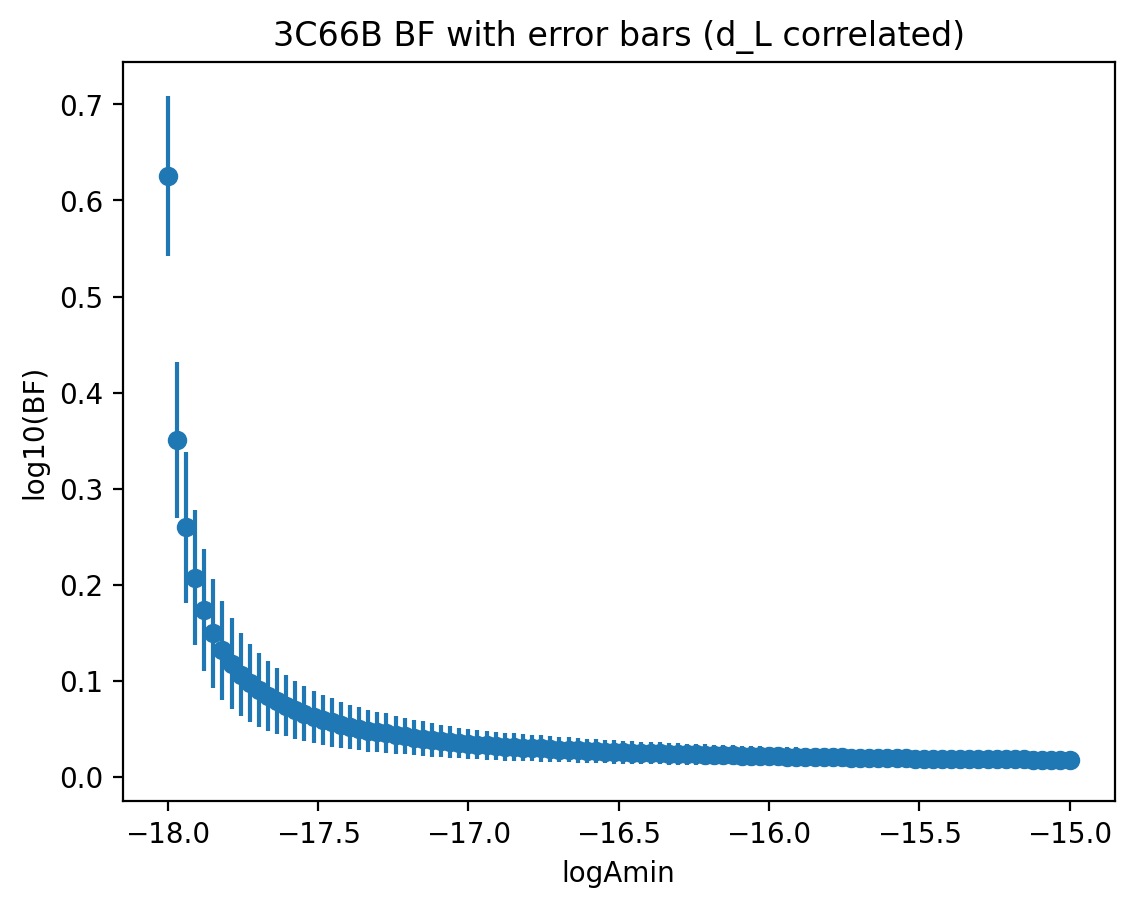

In [21]:
#d_L correlated SD BF
logamins = np.linspace(logAmin_dL, -15, 100)
BF_arr = []
BF_err_arr = []

from enterprise_extensions import model_utils
for logamin in logamins:
    BF,BF_err = model_utils.bayes_fac(samples = samples2plot[d_L_mask,4], logAmin=logamin, logAmax=-11)
    BF_arr.append(BF)
    BF_err_arr.append(BF_err)

plt.errorbar(logamins, BF_arr, yerr=BF_err_arr, fmt='o')
plt.xlabel('logAmin')
plt.ylabel("log10(BF)")
plt.title("3C66B BF with error bars (d_L correlated)")
plt.show()

In [22]:
print(BF_arr[0:10])

[0.6257238759347236, 0.3505250965332528, 0.25968633059505636, 0.20751783953523337, 0.17351262964781738, 0.1495464880989773, 0.13177344364484964, 0.11784120731637487, 0.10644520823044414, 0.09753067532446924]


In [23]:
print(BF_err_arr[0:10])

[0.08316359782134561, 0.08134798676235509, 0.0781517677912283, 0.06994892756004159, 0.06323466900041025, 0.05697387337745696, 0.051813708511301716, 0.04748389805402406, 0.04347492529947204, 0.04081495235822316]


In [24]:
#Non d_L correlated SD BF
from enterprise_extensions import model_utils
BF,BF_err = model_utils.bayes_fac(samples = samples_cold[0][::10,4], logAmax=-11)
print('log10A BF = ', BF, " +- ", BF_err)

log10A BF =  0.629895419885749  +-  0.0011152951746511936


In [25]:
#d_L correlated SD BF
BF,BF_err = model_utils.bayes_fac(samples = samples2plot[d_L_mask,4], logAmax=-11)
print('log10A BF = ', BF, " +- ", BF_err)

log10A BF =  0.6260254649057668  +-  0.08331879733108874


log10A BF =  0.6260254649057668  +-  0.08331879733108874


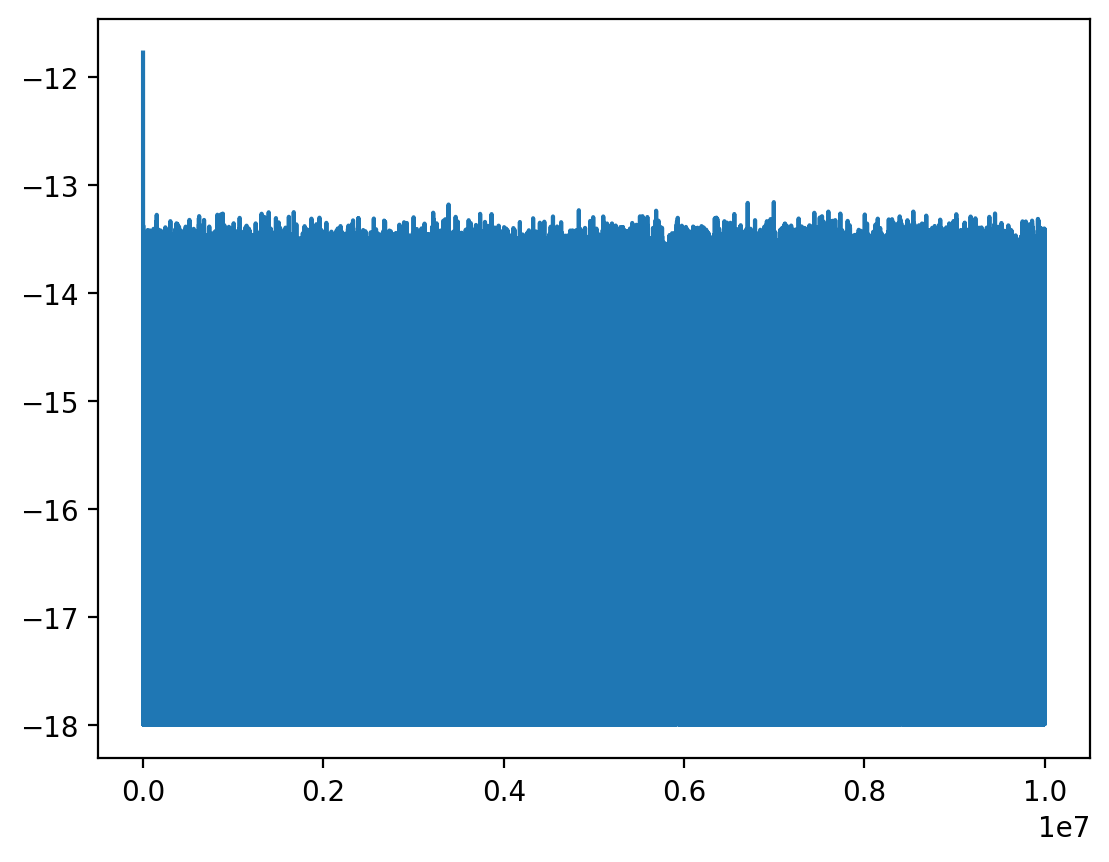

In [26]:
#d_L correlated SD BF
BF,BF_err = model_utils.bayes_fac(samples = samples_cold[0][int(1e7) + d_L_mask,4], logAmax=-11)
print('log10A BF = ', BF, " +- ", BF_err)
plt.plot(samples_cold[0][::10,4])
plt.show()

log10A BF =  0.629895419885749  +-  0.0011152951746511936


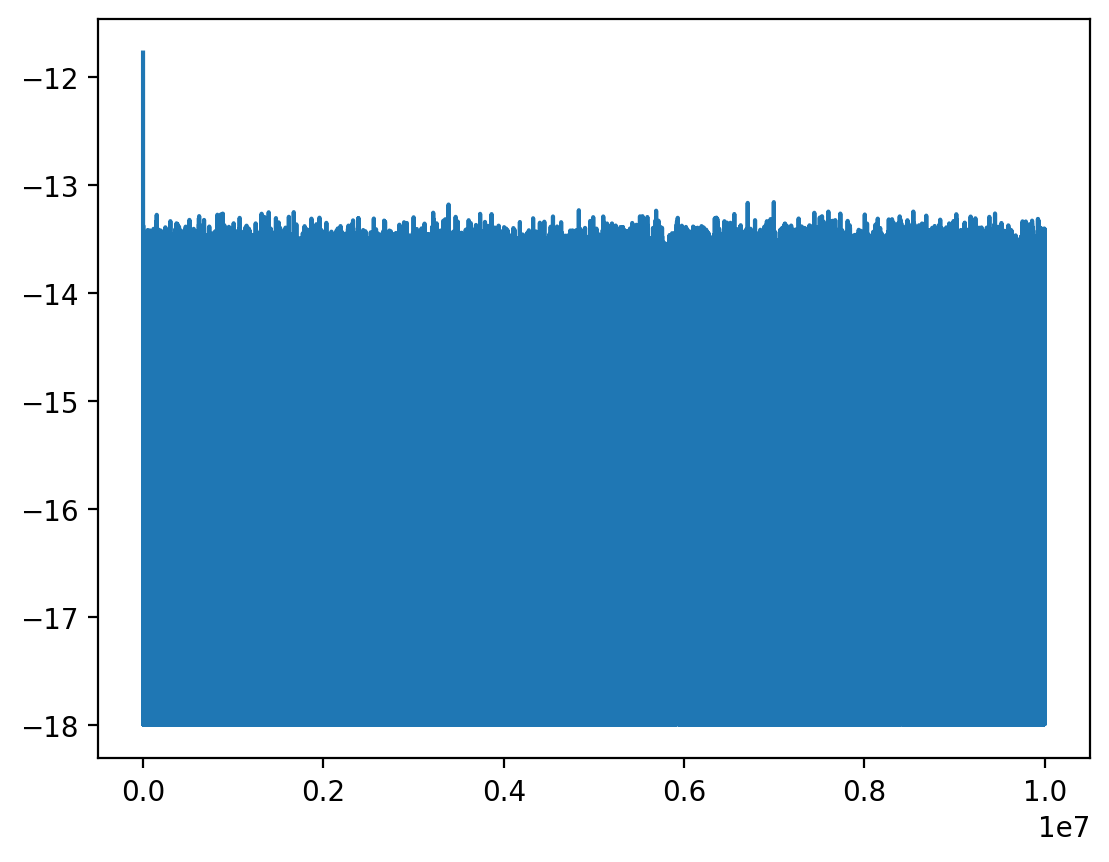

In [17]:
#Non d_L correlated SD BF
BF,BF_err = model_utils.bayes_fac(samples = samples_cold[0][::10,4], logAmax=-11)
print('log10A BF = ', BF, " +- ", BF_err)
plt.plot(samples_cold[0][::10,4])
plt.show()

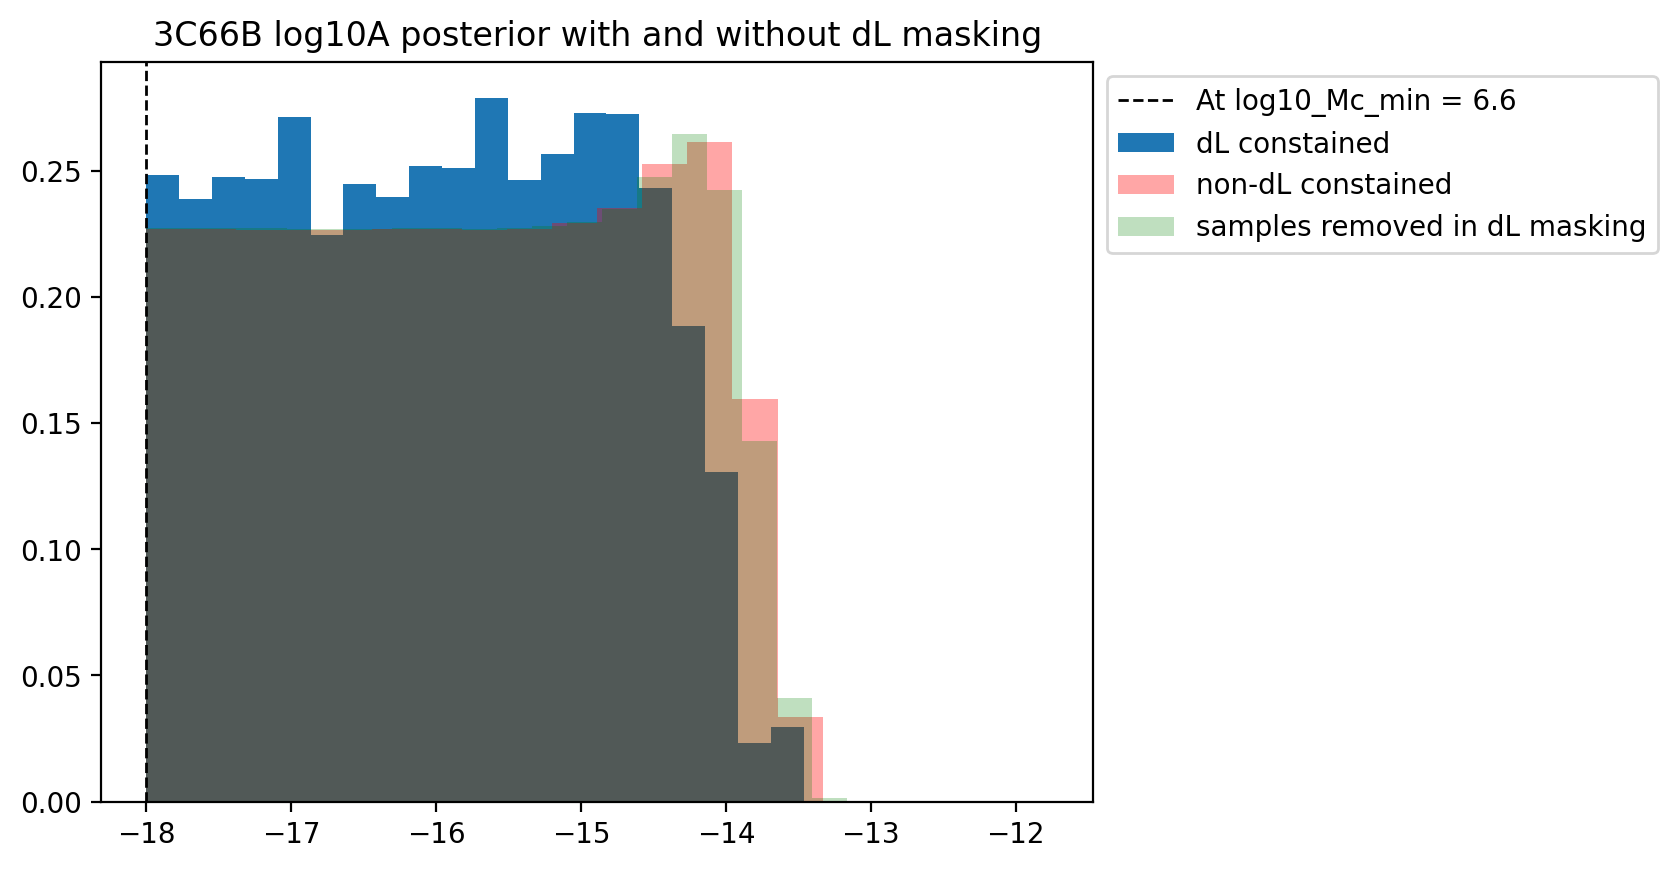

In [20]:
#logAmin_dL = np.min(samples2plot[d_L_mask,4])
#logAmax_dL = np.max(samples2plot[d_L_mask,4])
#print(logAmin_dL)
#print(len(samples2plot[d_L_mask,4]))

label = ['At log10_Mc_min = 6.6','dL constained', 'non-dL constained', 'samples removed in dL masking',]

plt.hist(samples2plot[d_L_mask,4], bins=20, density=True)
plt.hist(samples_cold[0][::10,4], bins=20, density=True,color = 'red',alpha=0.35)
plt.hist(samples2plot[merged_non_dL,4], bins=20, density=True,color = 'green',alpha=0.25)
plt.axvline(x = -18,color='k', linestyle='dashed', linewidth=1)
#plt.hist(samples2plot[not_d_L_mask_2,4], bins=20, density=True,color = 'green',alpha=0.25)
#plt.hlines(1/(-11 - logAmin_dL), logAmin_dL, -11,  color='red')

plt.legend(label,bbox_to_anchor=(1, 1), loc='upper left')
plt.title("3C66B log10A posterior with and without dL masking")
plt.show()

In [ ]:
print(samples_cold.shape)
print(d_L_mask)
plt.plot(samples_cold[0][int(1e7) + d_L_mask,4])
plt.show()
sample1 = samples_cold[0][int(1e7):]
plt.plot(sample1[d_L_mask,4])
plt.show()
plt.hist(sample1[d_L_mask,4], bins=20)
plt.show()

In [ ]:
'''#All wrong
from enterprise_extensions import model_utils
BF,BF_err = model_utils.bayes_fac(samples = samples_cold[0][::10,4], logAmax=-14.6)
print('log10A BF = ', BF, " +- ", BF_err)

MCBF,MCBF_err =model_utils.bayes_fac(samples = samples_cold[0][::10,5], logAmin =7.33, logAmax= 8.65)
print('Mc BF = ', MCBF, " +- ", MCBF_err)

freqBF,freqBF_err =model_utils.bayes_fac(samples = samples_cold[0][::10,3], logAmin = -7.25 ,logAmax=-7.2)
print('freq BF = ', freqBF, " +- ", freqBF_err)
'''

In [ ]:
'''
f_min = 1e-9
f_max = 3e-7
print(f_min, f_max)

n_bins = 45#20#50

fbins = np.linspace(np.log10(f_min), np.log10(f_max), n_bins+1)
print(10**fbins[11], 10**fbins[12])

#set burnin and thinning
#burnin = 10_000
burnin = 100_000
thin = 1

log10_f = samples_cold[0][burnin::thin,3]
log10_A = samples_cold[0][burnin::thin,4]

"""n_bins = 50
#fmin = 10**(-8.704)
#fmax = 10**(-7.6)
fmin = -8.704
fmax = -7.6
fbins = np.linspace(fmin, fmax, n_bins+1)
print(fbins)
BFs = np.zeros(n_bins)"""

n_h_bin = 50
n_h_bin4err = 10
bins = np.linspace(-18,-11, n_h_bin)
#bins = np.linspace(-18,-11, 20)
prior_dens = 1/7.0

matplotlib.rcParams.update({'font.size': 12})

BFs = np.zeros(n_bins)
BF_errs = np.zeros(n_bins)
for i in range(n_bins):
    #f_mask = np.where((10**log10_f>fbins[i]) & (10**log10_f<fbins[i+1]))
    f_mask = np.where((log10_f>fbins[i]) & (log10_f<fbins[i+1]))
    hist = plt.hist(log10_A[f_mask], bins=bins, histtype='step', density=True,
                   color='xkcd:black', alpha=0.0)
    BFs[i] = prior_dens/hist[0][0]
    
    #h_autocorr = emcee.autocorr.integrated_time(log10_A[f_mask], c=10, quiet=True)
    #N_eff = np.where((log10_A[f_mask]>bins[0]) &  (log10_A[f_mask]<bins[1]))[0].size/h_autocorr
    #N_eff = log10_A[f_mask].size/h_autocorr
    #N_eff = np.where((log10_A[f_mask]>bins[0]) &  (log10_A[f_mask]<bins[1]))[0].size
    #print(h_autocorr, log10_A[f_mask].size, N_eff)
    #BF_errs[i] = BFs[i]/np.sqrt(N_eff)
    
    BF_errs[i] = np.std(prior_dens/hist[0][:n_h_bin4err])
    
    if BFs[i]>250.0 and BFs[i]<np.inf:
        plt.hist(log10_A[f_mask], bins=bins, histtype='step', density=True,
                 label="{0:.2f} nHz - {1:.2f} nHz: BF={2:.1f}".format(10**fbins[i]*1e9,
                                                                      10**fbins[i+1]*1e9,
                                                                      BFs[i]),
                 alpha=1.0)
        plt.gca().axhline(prior_dens/(BFs[i]+BF_errs[i]))
        plt.gca().axhline(prior_dens/(BFs[i]))
        plt.gca().axhline(prior_dens/(BFs[i]-BF_errs[i]))
        



plt.legend(loc=1, bbox_to_anchor=(1,0))
plt.yscale('log')
plt.gca().axhline(prior_dens, ls='--', color='xkcd:green')
    
print(BFs)  
'''

# SkyMap Check

In [ ]:
'''
#Figure 1a of Mingarelli + 2017
import astropy.constants as c
from astropy.coordinates import SkyCoord

RA_ra = np.mean(samples2plot[::,2])
DEC_ra= np.mean(np.pi/2-np.arccos(samples2plot[::,0]))

RA = RA_ra-np.pi
DEC = DEC_ra-np.pi/2

print(RA,DEC)


c = SkyCoord(ra = '16h44m52.7s', dec = '+43d07m52.9s')

RA_expect = c.ra.radian-np.pi
DEC_expect=c.dec.radian-np.pi/2
print(RA_expect,DEC_expect)
ax = plt.subplot(111, projection='mollweide')
ax.grid()
ax.scatter(RA,DEC, edgecolors='none',  alpha=1, rasterized=True, label = 'QuickCW')
ax.plot(RA_expect,DEC_expect, color='m', marker='*',  alpha=1, rasterized=True,markersize=12,label='Direct From Coordinates')
#ax.plot(30,-15)
plt.legend()
plt.suptitle("HS1630 loc param dist",  y=0.15)
#plt.savefig("2MASS_galaxies.pdf")
'''

In [ ]:
import matplotlib.projections as pltProj

pltProj.get_projection_names()

## UL vs. frequency

In [ ]:
#official_11yr_skyavg = np.loadtxt("../data/11yr_ul_skyavg_DE436.txt")

In [ ]:

#%%time
plt.rcParams.update({'font.size': 18})

#burnin = 100_000
burnin = 10000000
thin = 1
#thin = 10*int(np.max([ccs[3],ccs[4]]))
print("Thin is",thin)

log10_fgws = samples_cold[burnin::thin,3]
log10_hs = samples_cold[burnin::thin,4]
print("fgws is",log10_fgws.size)


"""
f_bincenters = official_11yr_skyavg[1:67,0]
#f_bincenters = official_11yr_skyavg[1:8,0]
print(f_bincenters)
f_bins = []
for i in range(f_bincenters.shape[0]-1):
    f_bins.append(f_bincenters[i]-(f_bincenters[i+1]-f_bincenters[i])/2)
f_bins.append(f_bincenters[-1]-(f_bincenters[-1]-f_bincenters[-2])/2)
f_bins.append(f_bincenters[-1]+(f_bincenters[-1]-f_bincenters[-2])/2)
print(f_bins)
"""

f_min = 10**np.min(samples_cold[0][::1,3])
f_max = 10**np.max(samples_cold[0][::1,3])
print("fmin is",f_min,"fmax is", f_max)
#f_bins = np.linspace(f_min, f_max, int(f_max/f_min))
f_bins = np.arange(1,int(f_max/f_min)+1)*f_min
print("fbins is",f_bins)
print("fbins.size is",f_bins.size)

f_bincenters = []
for i in range(f_bins.size-1):
    f_bincenters.append((f_bins[i+1]+f_bins[i])/2)
print("f_bincenters is",f_bincenters)

log10_h_bins = np.linspace(-18,-11,100)

plt.figure(figsize=(8,7))
#h, xedges, yedges, _ = plt.hist2d(log10_fgws, log10_hs, bins=50, range=[[np.log10(3.5e-9),-7],[-18,-11]])
#h, xedges, yedges, _ = plt.hist2d(log10_fgws, log10_hs, bins=100, range=[[np.log10(3.5e-9),-7],[-15.5,-11]],
#                                  weights=log10_fgws*0+1/60.0)
h, xedges, yedges, _ = plt.hist2d(log10_fgws, log10_hs, bins=[np.log10(f_bins), log10_h_bins])

#make bin centers
bincenters = []
for i in range(xedges.size-1):
    bincenters.append((xedges[i+1]+xedges[i])/2)
bincenters = np.array(bincenters)

#print(xedges)
#print(bincenters)

freq_idx = np.digitize(log10_fgws, xedges)
#plt.scatter(log10_fgws[np.where(freq_idx==1)], log10_hs[np.where(freq_idx==1)])

N_bootstrap = 1000
#N_resample = 100

UL_freq = np.zeros(bincenters.size)
#UL_freq_reweight = np.zeros(bincenters.size)
#UL_freq_reweight_low = np.zeros(bincenters.size)
#UL_freq_reweight_high = np.zeros(bincenters.size)
UL_freq_error = np.zeros(bincenters.size)
for i in range(bincenters.size):
    print('---')
    print(i)
    hs = 10**log10_hs[np.where(freq_idx==i+1)]
    if hs.size==0:
        UL_freq[i] = 0.0
        continue
    
    UL_freq[i] = np.percentile(hs, 95)

    N_inbin = hs.shape[0]
    N_resample = int(N_inbin)

    print(N_inbin)

    #N_batch = int(N_inbin**(1/5))
    N_batch = 10
    if N_inbin<10*N_batch:
        N_batch=1
    print(N_batch)
    
    hs_batches = []
    for K in range(N_batch):
        hs_batches.append(hs[K*int(N_inbin/N_batch):(K+1)*int(N_inbin/N_batch)])

    ULs = np.zeros(N_bootstrap)
    for k in range(N_bootstrap):
        IDXS = np.random.choice(N_batch, size=N_batch, replace=True)
        hs_shuffle = np.block([hs_batches[J] for J in IDXS])
        ULs[k] = np.percentile(hs_shuffle, 95)
    
    UL_freq_error[i] = np.std(ULs)
    

plt.gca().axvline(x=-np.log10(3600*24*365.24), ls='--', lw=3, color='white', label='1/yr')
plt.gca().axvline(x=-np.log10(3600*24*365.24*0.5), ls=':', lw=3, color='white', label='2/yr')
#plt.plot(bincenters, UL_freq, ls='-', lw=3, marker='.', color="xkcd:red", label="95% UL")
#plt.errorbar(bincenters, np.log10(UL_freq), ls='-', lw=3, marker='x', color="xkcd:red",
#             label="95% UL - this run - old", alpha=0.3)
plt.errorbar(xedges[:-1], np.log10(UL_freq), ls='-', lw=3, color="xkcd:red",
             drawstyle='steps-post', label="95% UL - this run")
#plt.fill_between(bincenters, UL_freq_reweight_low, UL_freq_reweight_high,
#                 color="xkcd:red", alpha=0.3, label="95% UL")
#plt.plot(np.log10(official_11yr_skyavg[1:67,0]), np.log10(official_11yr_skyavg[1:67,1]),
 #        ls='--', lw=3, marker='x', color="xkcd:green", label="95% UL - official 11yr")
#plt.plot(np.log10(official_11yr_skyavg[:,0]), np.log10(official_11yr_skyavg[:,2]),
#         ls='--', lw=3, marker='.', color="xkcd:purple", label="95% UL - official2")
plt.ylim(-15,-11)
#plt.xlim(-8.75, -7.0)
plt.xlabel(r"$\log_{10} f_{\rm GW}$")
plt.ylabel(r"$\log_{10} A_{\rm e}$")

cbar = plt.colorbar(location='top')
cbar.set_label('#')

plt.legend(loc=2)

plt.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("Figs/UL_vs_freq.png", dpi=300)
plt.savefig("Figs/UL_vs_freq_new_seed.png", dpi=300)


In [ ]:
'''
#%%time
plt.rcParams.update({'font.size': 18})

#burnin = 100_000
burnin = 50_000
thin=1
#thin = 10*int(np.max([ccs[3],ccs[4]]))
print(thin)

log10_fgws = samples_cold[burnin::thin,3]
log10_hs = samples_cold[burnin::thin,4]
print(log10_fgws.size)


"""f_bincenters = official_11yr_skyavg[1:67,0]
#f_bincenters = official_11yr_skyavg[1:8,0]
print(f_bincenters)
f_bins = []
for i in range(f_bincenters.shape[0]-1):
    f_bins.append(f_bincenters[i]-(f_bincenters[i+1]-f_bincenters[i])/2)
f_bins.append(f_bincenters[-1]-(f_bincenters[-1]-f_bincenters[-2])/2)
f_bins.append(f_bincenters[-1]+(f_bincenters[-1]-f_bincenters[-2])/2)
print(f_bins)"""

f_min = 10**np.min(samples_cold[::10,3])
f_max = 10**np.max(samples_cold[::10,3])
print(f_min, f_max)
#f_bins = np.linspace(f_min, f_max, int(f_max/f_min))
f_bins = np.arange(1,int(f_max/f_min)+1)*f_min
print(f_bins)

f_bincenters = []
for i in range(f_bins.size-1):
    f_bincenters.append((f_bins[i+1]+f_bins[i])/2)
print(f_bincenters)

log10_h_bins = np.linspace(-18,-11,100)

plt.figure(figsize=(8,7))
#h, xedges, yedges, _ = plt.hist2d(log10_fgws, log10_hs, bins=50, range=[[np.log10(3.5e-9),-7],[-18,-11]])
#h, xedges, yedges, _ = plt.hist2d(log10_fgws, log10_hs, bins=100, range=[[np.log10(3.5e-9),-7],[-15.5,-11]],
#                                  weights=log10_fgws*0+1/60.0)
h, xedges, yedges, _ = plt.hist2d(log10_fgws, log10_hs, bins=[np.log10(f_bins), log10_h_bins])

#make bin centers
bincenters = []
for i in range(xedges.size-1):
    bincenters.append((xedges[i+1]+xedges[i])/2)
bincenters = np.array(bincenters)

#print(xedges)
#print(bincenters)

freq_idx = np.digitize(log10_fgws, xedges)
#plt.scatter(log10_fgws[np.where(freq_idx==1)], log10_hs[np.where(freq_idx==1)])

N_bootstrap = 1000
#N_resample = 100

UL_freq = np.zeros(bincenters.size)
#UL_freq_reweight = np.zeros(bincenters.size)
#UL_freq_reweight_low = np.zeros(bincenters.size)
#UL_freq_reweight_high = np.zeros(bincenters.size)
UL_freq_error = np.zeros(bincenters.size)
for i in range(bincenters.size):
    print('---')
    print(i)
    hs = 10**log10_hs[np.where(freq_idx==i+1)]
    if hs.size==0:
        UL_freq[i] = 0.0
        continue
    
    UL_freq[i] = np.percentile(hs, 95)

    N_inbin = hs.shape[0]
    N_resample = int(N_inbin)

    print(N_inbin)

    #N_batch = int(N_inbin**(1/5))
    N_batch = 10
    if N_inbin<10*N_batch:
        N_batch=1
    print(N_batch)
    
    hs_batches = []
    for K in range(N_batch):
        hs_batches.append(hs[K*int(N_inbin/N_batch):(K+1)*int(N_inbin/N_batch)])

    ULs = np.zeros(N_bootstrap)
    for k in range(N_bootstrap):
        IDXS = np.random.choice(N_batch, size=N_batch, replace=True)
        hs_shuffle = np.block([hs_batches[J] for J in IDXS])
        ULs[k] = np.percentile(hs_shuffle, 95)
    
    UL_freq_error[i] = np.std(ULs)
    

plt.gca().axvline(x=-np.log10(3600*24*365.24), ls='--', lw=3, color='white', label='1/yr')
plt.gca().axvline(x=-np.log10(3600*24*365.24*0.5), ls=':', lw=3, color='white', label='2/yr')
#plt.plot(bincenters, UL_freq, ls='-', lw=3, marker='.', color="xkcd:red", label="95% UL")
#plt.errorbar(bincenters, np.log10(UL_freq), ls='-', lw=3, marker='x', color="xkcd:red",
#             label="95% UL - this run - old", alpha=0.3)
plt.errorbar(xedges[:-1], np.log10(UL_freq), ls='-', lw=3, color="xkcd:red",
             drawstyle='steps-post', label="95% UL - this run")
#plt.fill_between(bincenters, UL_freq_reweight_low, UL_freq_reweight_high,
#                 color="xkcd:red", alpha=0.3, label="95% UL")
plt.plot(np.log10(official_11yr_skyavg[1:67,0]), np.log10(official_11yr_skyavg[1:67,1]),
         ls='--', lw=3, marker='x', color="xkcd:green", label="95% UL - official 11yr")
#plt.plot(np.log10(official_11yr_skyavg[:,0]), np.log10(official_11yr_skyavg[:,2]),
#         ls='--', lw=3, marker='.', color="xkcd:purple", label="95% UL - official2")
plt.ylim(-15,-11)
#plt.xlim(-8.75, -7.0)
plt.xlabel(r"$\log_{10} f_{\rm GW}$")
plt.ylabel(r"$\log_{10} A_{\rm e}$")

cbar = plt.colorbar(location='top')
cbar.set_label('#')

plt.legend(loc=2)

plt.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.savefig("Figs/UL_vs_freq.png", dpi=300)
#plt.savefig("Figs/UL_vs_freq_new_seed.png", dpi=300)

In [ ]:
plt.figure(figsize=(8,7))

plt.errorbar(10**bincenters, UL_freq, yerr=UL_freq_error,
             ls='', lw=2, marker='.', alpha=0., color="xkcd:red")

plt.errorbar(10**xedges[:-1], UL_freq, drawstyle='steps-post',
             ls='-', lw=2, marker='', alpha=1.0, color="xkcd:red", label="95% UL - this run\n(1-sigma errors)")

plt.errorbar(official_11yr_skyavg[1:67,0], official_11yr_skyavg[1:67,1],
             yerr=official_11yr_skyavg[1:67,2],
             ls='-', lw=2, marker='', color="xkcd:green", label="95% UL - official 11yr\n(1-sigma errors)")

plt.xscale('log')
plt.yscale('log')
plt.ylim(5e-15,4e-12)
plt.xlabel(r"$f_{\rm GW}$")
plt.ylabel(r"$A_{\rm e}$")

plt.legend(loc=2)